## Objectives of Preprocessing
    
- data should be a 2D array
- input data has to be numbers
- no nan or inf
- columns are scaled to similar ranges (mean=0, variance=1)
- columns should not be collinear (cx1!=k*cx2)
- rows should not be causally dependent
- data should be 100 times larger then the number of columns 

## Import Python Libraries 

In [1]:
import shutil
import os
import pathlib
from pprint import pprint
from pathlib import Path
import csv
import time 

In [2]:
import fiona
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling


import pandas as pd
import xgboost as xgb
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import matplotlib.pyplot as plt

In [3]:
%load_ext memory_profiler

## Define Input Datasets

- features 
- targets 
- out of sample 
- area of interest

In [4]:
%%time
%%memit


feature_file_paths = [
Path('/g/data/ge3/sheece/LOC_distance_to_coast.tif'),
Path('/g/data/ge3/sheece/mrvbf_9.tif'),
Path('/g/data/ge3/sheece/relief_mrvbf_3s_mosaic.tif'),
Path('/g/data/ge3/sheece/relief_elev_focalrange1000m_3s.tif'),
Path('/g/data/ge3/sheece/relief_elev_focalrange300m_3s.tif'),
Path('/g/data/ge3/sheece/saga_wetSM_85.tif'),
Path('/g/data/ge3/sheece/tpi_300.tif'),
Path('/g/data/ge3/sheece/slope_fill2.tif'),
Path('/g/data/ge3/sheece/dem_fill.tif'),
Path('/g/data/ge3/sheece/3dem_mag2.tif'),
Path('/g/data/ge3/sheece/3dem_mag1_fin.tif'),
Path('/g/data/ge3/sheece/3dem_mag0.fin.tif'),
Path('/g/data/ge3/sheece/relief_roughness.tif'),
Path('/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif'),
Path('/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif'),
Path('/g/data/ge3/sheece/Dose_2016.tif'),
Path('/g/data/ge3/sheece/Potassium_2016.tif'),
Path('/g/data/ge3/sheece/Thorium_2016.tif'),
Path('/g/data/ge3/sheece/Rad2016U_Th.tif'),
Path('/g/data/ge3/sheece/Rad2016K_Th.tif'),
Path('/g/data/ge3/sheece/national_Wii_RF_multirandomforest_prediction.tif'),
Path('/g/data/ge3/sheece/si_geol1.tif'),
Path('/g/data/ge3/sheece/ceno_euc_aust1.tif'),
Path('/g/data/ge3/sheece/Grav_lane_clip.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg_BLUE+SWIR2.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-RED.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-GREEN.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-l8-all-85m-avg-BLUE.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-l8-all-85m-avg-NIR.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-SWIR1.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/be-30y-85m-avg-SWIR2.filled.lzw.nodata.tif'),
Path('/g/data/ge3/sheece/s2-dpca-85m.tif'),
Path('/g/data/ge3/sheece/water-85m.tif'),
Path('/g/data/ge3/sheece/clim_EPA_albers.tif'),
Path('/g/data/ge3/sheece/Clim_Prescott_LindaGregory.tif'),
Path('/g/data/ge3/sheece/clim_PTA_albers.tif'),
Path('/g/data/ge3/sheece/clim_WDA_albers.tif'),
Path('/g/data/ge3/sheece/clim_RSM_albers.tif'),
Path('/g/data/ge3/sheece/LONGITUDE_GRID1_clip.tif')
]

#target dataset small
# /g/data/ge3/sheece/0_50cm_2021_albers_C_sm_T_resampled_small.shp
#target dataset complete
# /g/data/ge3/sheece/0_50cm_2021_albers_C_sm_T_resampled.shp
target_file_path = Path("/g/data/ge3/sheece/0_50cm_2021_albers_C_sm_T_resampled.shp")

# define a shape for area of interest
area_of_interest_file_path = None

#OOS
# /g/data/ge3/sheece/0_50cm_2021_albers_C_oos.shp
out_of_sample_file_path = Path("/g/data/ge3/sheece/0_50cm_2021_albers_C_oos.shp")

root = Path('/g/data/ge3/sheece')

peak memory: 188.05 MiB, increment: 0.28 MiB
CPU times: user 65.2 ms, sys: 17.8 ms, total: 82.9 ms
Wall time: 213 ms


In [5]:
%%time
%%memit

# remove any duplicate datasets in input 

temp_feature_file_paths = feature_file_paths.copy()
unique_values = list(set(temp_feature_file_paths))
for unique_value in unique_values:
    temp_feature_file_paths.remove(unique_value)

print("Following are duplicates:")
print(temp_feature_file_paths)

feature_file_paths = list(set(feature_file_paths))

Following are duplicates:
[PosixPath('/g/data/ge3/sheece/LATITUDE_GRID1_clip.tif'), PosixPath('/g/data/ge3/sheece/be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata.tif')]
Following are duplicates:
[]
Following are duplicates:
[]
Following are duplicates:
[]
Following are duplicates:
[]
Following are duplicates:
[]
Following are duplicates:
[]
peak memory: 188.11 MiB, increment: 0.03 MiB
CPU times: user 80.8 ms, sys: 26.4 ms, total: 107 ms
Wall time: 229 ms


In [6]:
# ensure that that dataset provided in input exist
import os.path
for feature_file_path in feature_file_paths:
    if not os.path.isfile(feature_file_path):
        feature_file_paths.remove(feature_file_path)
        print ("File not exist",feature_file_path)        


## Standardising Datasets

In [7]:
%%time
%%memit

# check for multiple bands
# if a dataset contains more then one band then create a new dataset for each band

for feature_file_path in feature_file_paths:
    with rasterio.open(feature_file_path) as dataset:
        if len(dataset.indexes) >1: 
            print("Processing dataset: ",feature_file_path)
            for band in dataset.indexes:
                path_to_new_dataset = root/ str(feature_file_path.stem +"_"+str(band)+".tif")
                print("Reading data from band: ",band)
                new_dataset = rasterio.open(
                    path_to_new_dataset,
                     'w',
                     driver='GTiff',
                     height=dataset.shape[0],
                     width=dataset.shape[1],
                     count=1,
                     dtype=dataset.meta['dtype'],
                     crs=dataset.crs,
                     transform=dataset.transform
                )
                
                new_dataset.write(dataset.read(band),1)
                new_dataset.close()
                print("New dataset added:",path_to_new_dataset)
                feature_file_paths.append(path_to_new_dataset)
    
            print("Removing multiband dataset:",feature_file_path)
            feature_file_paths.remove(feature_file_path)

Processing dataset:  /g/data/ge3/sheece/s2-dpca-85m.tif
Reading data from band:  1
New dataset added: /g/data/ge3/sheece/s2-dpca-85m_1.tif
Reading data from band:  2
New dataset added: /g/data/ge3/sheece/s2-dpca-85m_2.tif
Reading data from band:  3
New dataset added: /g/data/ge3/sheece/s2-dpca-85m_3.tif
Removing multiband dataset: /g/data/ge3/sheece/s2-dpca-85m.tif
Processing dataset:  /g/data/ge3/sheece/water-85m.tif
Reading data from band:  1
New dataset added: /g/data/ge3/sheece/water-85m_1.tif
Reading data from band:  2
New dataset added: /g/data/ge3/sheece/water-85m_2.tif
Reading data from band:  3
New dataset added: /g/data/ge3/sheece/water-85m_3.tif
Removing multiband dataset: /g/data/ge3/sheece/water-85m.tif
peak memory: 16225.82 MiB, increment: 16037.71 MiB
CPU times: user 8.38 s, sys: 17.9 s, total: 26.3 s
Wall time: 26.9 s


In [8]:
# import os
# # /home/547/sg4953/venvs/uncoverml_gadi/lib/python3.7/site-packages/pyproj/proj_dir/share/proj/proj.db
# # /apps/proj/6.2.1/share/proj/proj.db
# # '/home/547/sg4953/venvs/uncoverml_gadi/lib/python3.7/site-packages/rasterio/proj_data/proj.db' 
# os.environ['PROJ_LIB'] = '/apps/proj/6.2.1/share/proj' 
# # os.environ['GDAL_DATA'] = 'C:\\Users\\Sai kiran\\anaconda3\\envs\sai\\Library\\share'
# # os.environ['PROJ_LIB'] = 'C:\\Users\\Sai kiran\\anaconda3\\envs\\sai\\Library\\share\\proj'
# # os.environ['GDAL_DATA'] = 'C:\\Users\\Sai kiran\\anaconda3\\envs\sai\\Library\\share'

In [9]:
%%time
%%memit

# check projection
# if a dataset in not in EPSG:3577; reproject it in EPSG:3577 projection


crs_epsg3577 = rasterio.crs.CRS.from_string('EPSG:3577')

for feature_file_path in feature_file_paths:
    with rasterio.open(feature_file_path) as src:
        if crs_epsg3577 != src.crs:
            print("Converting dataset: "+str(feature_file_path))
            transform, width, height = calculate_default_transform(
                src.crs, 
                crs_epsg3577, 
                src.width, 
                src.height, 
                *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({'crs': crs_epsg3577,'transform': transform, 'width': width,'height': height})

            new_feature_file_path = feature_file_path.parent /str(feature_file_path.stem+"_reprojected.tif")
            with rasterio.open(new_feature_file_path, 'w', **kwargs) as dst:
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs_epsg3577,
                    resampling=Resampling.nearest)
            feature_file_paths.remove(feature_file_path)
            feature_file_paths.append(new_feature_file_path)
            print("Dataset: ",feature_file_path, " has been reprojected and saved as: ",new_feature_file_path)


Converting dataset: /g/data/ge3/sheece/saga_wetSM_85.tif
Dataset:  /g/data/ge3/sheece/saga_wetSM_85.tif  has been reprojected and saved as:  /g/data/ge3/sheece/saga_wetSM_85_reprojected.tif
peak memory: 8270.50 MiB, increment: 0.66 MiB
CPU times: user 16.4 s, sys: 5.77 s, total: 22.2 s
Wall time: 23.2 s


In [10]:
%%time
%%memit

# check for area of interest 
# if a user has provided a smaller area of interest then crop the input datasets accordingly
import fiona
import rasterio
from rasterio.mask import mask

if area_of_interest_file_path is not None:
    
    # apply crop to feature datasets 
    with fiona.open(area_of_interest_file_path) as shapefile:
        geoms = [feature["geometry"] for feature in shapefile]

    for feature_file_path in feature_file_paths:
        if "cropped" not in feature_file_path.name:
            print("Cropping : "+feature_file_path.stem)
            # load the raster, mask it by the polygon and crop it
            with rasterio.open(feature_file_path) as src:
                out_image, out_transform = mask(src, geoms, crop=True)
            out_meta = src.meta.copy()

            # save the resulting raster  
            out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
            })   

            with rasterio.open(root/(feature_file_path.stem+'_cropped.tif'), "w", **out_meta) as dest:
                dest.write(out_image)

            shutil.move(feature_file_path, root/("old/"+feature_file_path.name))
    
    # apply crop to target vector files(.shp)
    if "cropped" not in target_file_path.name:
        print("Cropping: "+target_file_path.name)
        clipped_file = root/(target_file_path.stem+'_cropped.shp')
        callstr = ['ogr2ogr',
                   '-clipsrc',
                   area_of_interest_file_path,
                   clipped_file,
                   target_file_path] 
        proc = subprocess.Popen(callstr, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        stdout,stderr=proc.communicate()

        shutil.move(target_file_path, root/("old/"+target_file_path.name))
else:
    print("No are of interest provided.")

No are of interest provided.
No are of interest provided.
No are of interest provided.
No are of interest provided.
No are of interest provided.
No are of interest provided.
No are of interest provided.
peak memory: 8268.05 MiB, increment: 0.46 MiB
CPU times: user 85.7 ms, sys: 540 ms, total: 625 ms
Wall time: 912 ms


## Create training dataset

In [11]:
%%time
%%memit
# create a vector csv file from the input datasets
# this csv file will be used by different machine learning algorithms

print(time.ctime())
# create iterators to inputs feature dataset and target dataset
datasets = []
for feature_file_path in feature_file_paths: 
    datasets.append(rasterio.open(feature_file_path))

target_handle = fiona.open(target_file_path)

# create the first row containing col names
head_row = ['target']
for feature_file_path in feature_file_paths:
    head_row.append(feature_file_path.stem)
head_row.append("x")
head_row.append("y")
    
csv_rowlist = [head_row]

if not os.path.isdir("../data"):
    os.mkdir("../data") 
    
with open('../data/input_dataset.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Iterate through list of targets
    print("Creating csv file ...... ")
    print("Please wait. It will take about 30 mins.")
    for target in target_handle:
        value = target["properties"]["con"]
        x, y = target["geometry"]["coordinates"]
        new_row = [value]
        
        # Iterate through list of features
        for dataset in datasets:
            new_row.append(next(dataset.sample([(x, y)]))[0])
        new_row.append(x)
        new_row.append(y)
        
        csv_rowlist.append(new_row)
        
        # load 1000 rows in memory then write them to csv
        # this reduces the I/O operations required and speeds up creating csv file 
        if len(csv_rowlist)%1000==0:
            writer.writerows(csv_rowlist)
            csv_rowlist = []

print("Output file has been created.")
# close iterators
target_handle.close()
for dataset in datasets: 
    dataset.close()

Thu Feb  4 12:09:15 2021
Creating csv file ...... 
Please wait. It will take about 30 mins.
Output file has been created.
peak memory: 20479.67 MiB, increment: 12211.45 MiB
CPU times: user 20min 27s, sys: 1min 41s, total: 22min 9s
Wall time: 24min 10s


## Create Out of sample dataset

In [12]:
%%time
%%memit

# Create a vector csv file from the input datasets
# This csv file will be used by different machine learning algorithms

# Create iterators to inputs feature dataset and target dataset
datasets = []
for feature_file_path in feature_file_paths: 
    datasets.append(rasterio.open(feature_file_path))

out_of_sample_handle = fiona.open(out_of_sample_file_path)

# create the first row containing col names
head_row = ['target']
for feature_file_path in feature_file_paths:
    head_row.append(feature_file_path.stem)
head_row.append("x")
head_row.append("y")
    
csv_rowlist = [head_row]

if not os.path.isdir("../data"):
    os.mkdir("../data") 
    
with open('../data/oos_dataset.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # iterate through list of targets
    print("Creating csv file ...... ")
    print("Please wait.")
    for target in out_of_sample_handle:
        value = target["properties"]["con"]
        x, y = target["geometry"]["coordinates"]
        new_row = [value]
        
        # iterate through list of features
        for dataset in datasets:
            new_row.append(next(dataset.sample([(x, y)]))[0])
        new_row.append(x)
        new_row.append(y)
        
        csv_rowlist.append(new_row)
        
        # load 1000 rows in memory then write them to csv
        # this reduces the I/O operations required and speeds up creating csv file 
        if len(csv_rowlist)%1000==0:
            writer.writerows(csv_rowlist)
            csv_rowlist = []

print("Output file has been created.")
# close iterators
out_of_sample_handle.close()
for dataset in datasets: 
    dataset.close()

Creating csv file ...... 
Please wait.
Output file has been created.
peak memory: 19540.70 MiB, increment: 0.96 MiB
CPU times: user 12.1 s, sys: 21 s, total: 33 s
Wall time: 1min 17s


## Cleaning training dataset

In [13]:
%%time
%%memit

input_file = '../data/input_dataset.csv'
print("input_file: ",input_file)
df = pd.read_csv(input_file)
input_shape = df.shape

# drop positional arguments 
df = df.drop(["x","y"],axis=1).astype('float32') 

# drop no data values
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]

# write updated dataframe to csv file
df.to_csv("../data/formated_dataset.csv",index=None,header=df.columns.values)

output_shape = df.shape
print("Number of rows removed: ",input_shape[0]-output_shape[0])
print("Number of cols removed: ",input_shape[1]-output_shape[1])


input_file:  ../data/input_dataset.csv
Number of rows removed:  1682
Number of cols removed:  2
peak memory: 19549.03 MiB, increment: 8.35 MiB
CPU times: user 16.5 s, sys: 1.49 s, total: 18 s
Wall time: 19.7 s


## Cleaning oos dataset

In [14]:
%%time
%%memit

oos_input_file = '../data/oos_dataset.csv'
print("input_file: ",oos_input_file)
df = pd.read_csv(oos_input_file)
input_shape = df.shape

# drop positional arguments 
df = df.drop(["x","y"],axis=1).astype('float32') 

# drop no data values
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]

# write updated dataframe to csv file
df.to_csv("../data/formated_oos_dataset.csv",index=None,header=df.columns.values)

output_shape = df.shape
print("Number of rows removed: ",input_shape[0]-output_shape[0])
print("Number of cols removed: ",input_shape[1]-output_shape[1])


input_file:  ../data/oos_dataset.csv
Number of rows removed:  72
Number of cols removed:  2
input_file:  ../data/oos_dataset.csv
Number of rows removed:  72
Number of cols removed:  2
peak memory: 19545.75 MiB, increment: 1.25 MiB
CPU times: user 156 ms, sys: 540 ms, total: 695 ms
Wall time: 1.32 s


## Save Normalized Dataset

#### perform maximum absolute transformation 

In [15]:
# %%time
# %%memit

# def maximum_absolute_scaling(df):
#     # copy the dataframe
#     df_scaled = df.copy()
#     # apply maximum absolute scaling
#     for column in df_scaled.columns:
#         df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
#     return df_scaled

# input_training_file = '../data/formated_dataset.csv'
# input_oos_file = '../data/formated_oos_dataset.csv'

# print("input_file: ",input_file)
# df = pd.read_csv(input_file)
# df = maximum_absolute_scaling(df)
# df.to_csv("../data/max_abs_df.csv",index=None,header=df.columns.values)
# print("output_file: ../data/max_abs_df.csv")

#### perform quantile transformation 

In [16]:
%%time
%%memit


input_training_file = '../data/formated_dataset.csv'
input_oos_file = '../data/formated_oos_dataset.csv'

print("input_training_file: ",input_training_file)
df = pd.read_csv(input_training_file)
scaler = preprocessing.QuantileTransformer().fit(df)

quantile_df = scaler.transform(df)
pd.DataFrame(quantile_df).to_csv("../data/quantile_df.csv",index=None,header=df.columns.values)

df = pd.read_csv(input_oos_file)
quantile_df = scaler.transform(df)
pd.DataFrame(quantile_df).to_csv("../data/quantile_oos_df.csv",index=None,header=df.columns.values)


print("output: quantile_df, quantile_oos_df")


input_training_file:  ../data/formated_dataset.csv
output: quantile_df, quantile_oos_df
peak memory: 19551.35 MiB, increment: 6.79 MiB
CPU times: user 30.2 s, sys: 1.12 s, total: 31.4 s
Wall time: 33 s


#### perform standard scaler transformation 

In [17]:
%%time
%%memit

input_training_file = '../data/formated_dataset.csv'
input_oos_file = '../data/formated_oos_dataset.csv'

print("input_training_file: ",input_training_file)
df = pd.read_csv(input_training_file)
scaler = preprocessing.StandardScaler().fit(df)

scaled_df = scaler.transform(df)
pd.DataFrame(quantile_df).to_csv("../data/scaler_df.csv",index=None,header=df.columns.values)

df = pd.read_csv(input_oos_file)
scaled_df = scaler.transform(df)
pd.DataFrame(quantile_df).to_csv("../data/scaler_oos_df.csv",index=None,header=df.columns.values)



print("output: scaler_df, scaler_oos_df")


input_training_file:  ../data/formated_dataset.csv
output: scaler_df, scaler_oos_df
peak memory: 19546.66 MiB, increment: 0.55 MiB
CPU times: user 2.62 s, sys: 595 ms, total: 3.22 s
Wall time: 3.82 s


## Exploring Normalization
- Rescaling (min-max normalization)
- Standardization (Z-scale normalization)



peak memory: 19546.74 MiB, increment: 0.34 MiB
CPU times: user 214 ms, sys: 522 ms, total: 736 ms
Wall time: 1.3 s


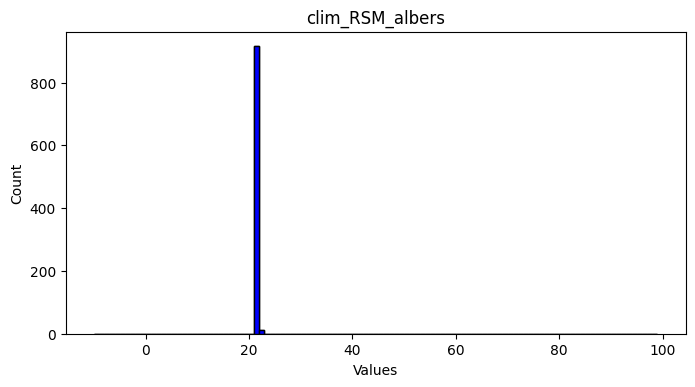

In [18]:
%%time
%%memit

## density plots for input features
dataset_id = 23
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
col_name = df.columns.values[dataset_id]
plt.xlabel('Values')
plt.ylabel('Count')
plt.title(col_name)
_ = plt.hist(df[col_name], color = 'blue', edgecolor = 'black', bins = np.arange(-10,100,1),label=col_name )

peak memory: 19550.54 MiB, increment: 2.35 MiB
CPU times: user 163 ms, sys: 552 ms, total: 716 ms
Wall time: 1.2 s


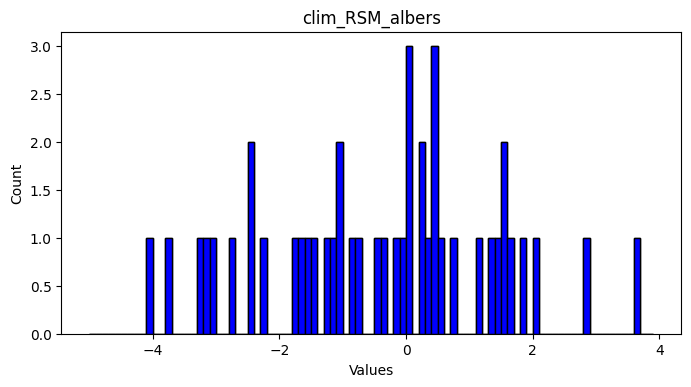

In [19]:
%%time
%%memit


plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
col_name = df.columns.values[dataset_id]
plt.xlabel('Values')
plt.ylabel('Count')
plt.title(col_name)
_ = plt.hist(scaled_df[dataset_id], color = 'blue', edgecolor = 'black', bins = np.arange(-5,4,0.1),label=col_name )

peak memory: 19550.92 MiB, increment: 0.00 MiB
CPU times: user 157 ms, sys: 489 ms, total: 646 ms
Wall time: 1.15 s


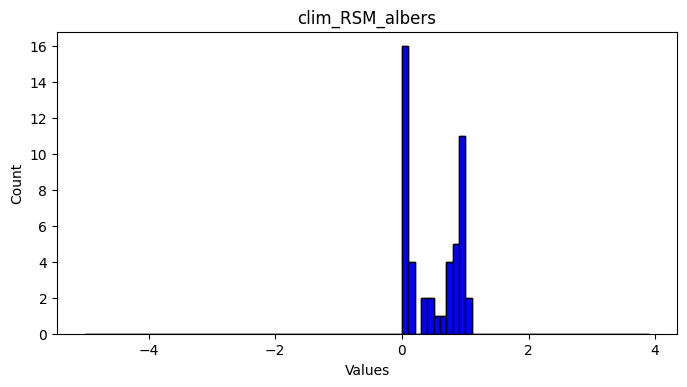

In [20]:
%%time
%%memit

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
col_name = df.columns.values[dataset_id]
plt.xlabel('Values')
plt.ylabel('Count')
plt.title(col_name)
_ = plt.hist(quantile_df[dataset_id], color = 'blue', edgecolor = 'black', bins = np.arange(-5,4,0.1),label=col_name )

### references